In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from settings  import *
from preprocessing import *
import mne
import dataset as ds
from train import *
import decode as dec
from importlib import reload

from models import Relative_Positioning, StagerNet, Decoder
from dataset import Decoder_Dataset, DecoderSampler, SequentialSampler
import process
from train import load_losses, save_losses
from torch import nn, optim
import argparse 
reload(process)
reload(dec)
reload(ds)

<module 'dataset' from '/home/brain/EEG-ssl/dataset.py'>

In [2]:
# models params
C = 64
T =1000
M = 600
#training paramms
epochs = 20
batch_size = 40
lr = 1e-3
resume = False
#datasets params
n_train = 22000
n_test = 3000
#sampling params
pos= 4000
neg = 8000

s_weights = [0.5, 1-0.5]

In [3]:
import torch
from torch.nn import *
from pylab import *
from torch import optim
from torch.utils import data
from torch import nn
from torch.nn.functional import soft_margin_loss

In [ ]:
import numpy as np # linear algebra
import os
from settings  import *
from preprocessing import *
from models import Relative_Positioning, StagerNet, Decoder
from dataset import Decoder_Dataset, DecoderSampler, collate
import process
from train import load_losses, save_losses
from torch import nn, optim
import argparse 
from get_results import *

In [4]:
subjects = SUBJECTS[:-2]

In [5]:
import gc
gc.collect()

7

In [6]:
torch.cuda.empty_cache()

In [7]:
ssl_model = Relative_Positioning(StagerNet,C , T, embedding_dim = M )
model = ssl_model.feature_extractor

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, EEG_FeatureExtractor, aggregator,  C, T, embedding_dim=100, hidden_dim= 20):
        super().__init__()
        self.feature_extractor = EEG_FeatureExtractor
        self.embedding_dim = embedding_dim
        self.C = C
        self.T = T
        #self.feature_extractor.float()
        self.linear1 = nn.Linear(embedding_dim//2, 12)
        self.aggr = nn.AdaptiveAvgPool2d((1,300))
        self.loss_fn = nn.CrossEntropyLoss()
        self.flatten = nn.Flatten()
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        batch = x.shape[1]#pad
        x = x.reshape(-1, 1, self.C, self.T)
        x = self.feature_extractor(x)
        x = x.reshape(-1, batch,self.embedding_dim ).permute(1,0,2)
        x = self.aggr(x)
        x= self.flatten(x)
        x = self.relu(x)
        x = self.linear1(x)
        return x.squeeze(dim = 0)

In [9]:
class Dummy(nn.Module):
    
    def __init__(self ):
        super().__init__()
        #self.feature_extractor = EEG_FeatureExtractor
        #self.feature_extractor.float()
        self.aggr = nn.AdaptiveAvgPool3d((1,5,1000))
        self.linear1 = nn.Linear(5000, 12)
        self.loss_fn = nn.CrossEntropyLoss()
        self.flatten = nn.Flatten()
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        
        #x = self.flatten(x.unsqueeze(dim = 0))
        x = self.aggr (x.permute(1,0,2,3))
        x= self.flatten(x)
        x = self.relu(x)
        x = self.linear1(x)
        print(x.shape)
        return x.squeeze(dim = 0)

In [10]:
#ssl_model = Relative_Positioning(StagerNet,C , T, embedding_dim = M )
#ssl_model.load_state_dict(torch.load(os.path.join(ROOT, 'saved_models', 'ssl_model_epoch40.pt')))
#model = ssl_model.feature_extractor
#subjects = SUBJECTS[:-2]
#val_subjects = [SUBJECTS[-2]]

In [10]:
#decoder =Dummy()
#decoder.to(float).to(DEVICE)

Dummy(
  (aggr): AdaptiveAvgPool3d(output_size=(1, 5, 1000))
  (linear1): Linear(in_features=5000, out_features=12, bias=True)
  (loss_fn): CrossEntropyLoss()
  (flatten): Flatten()
  (relu): ReLU()
)

In [11]:
decoder = Decoder(model, 0, C, T, embedding_dim=M, hidden_dim = 20)
decoder.to(DEVICE).float();

In [12]:
from dataset import *

In [13]:

def collate(batch):
   
    samples= pad_sequence([item[0] for item in batch])
    targets =torch.tensor( [item[1] for item in batch])
    
    return samples, targets

In [ ]:
def get_test_results(model, test_loader):
    y_true = []
    y_pred = []
    model.eval()
    softmax = nn.Softmax(dim = 1)
    with torch.no_grad():
        
        for x, y in test_loader:
            
            x = x.to(DEVICE).to(float).contiguous().squeeze(dim= 2)
            y = y.to(DEVICE).to(float).contiguous()
            out = model(x)
            _, predicted = torch.max(softmax(out), 1)
            y_true.extend(list(y.cpu().numpy()))
            y_pred.extend(list(predicted.cpu().numpy()))
    return y_true, y_pred

def decoder_scores(model, subjects, trials):
    
    test_dataset = Decoder_Dataset(subjects,trials, T, step = 512)
    test_sampler = SequentialSampler(test_dataset, batch_size = 168, weights = [1/12]*12, size = 168)
    test_loader = torch.utils.data.DataLoader(test_dataset, num_workers=0,
                                          sampler = test_sampler)
    y_true, y_pred = get_test_results(model, test_loader)
    acc_score = accuracy_score(y_true, y_pred)
    balanced_acc_score = balanced_accuracy_score(y_true, y_pred)
    print(f'Performance of the network on the test trials:')
    print(f'\tAccuracy: {100*acc_score:.2f}%')
    print(f'\tBalanced accuracy: {100*balanced_acc_score:.2f}%')
    return acc_score, balanced_acc_score



In [14]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from torch.nn.utils.rnn import pad_sequence
softmax = nn.Softmax(dim = 1)
def _train_dec(model, train_loader, optimizer, epoch):
    
    model.train()
    train_losses = []
    y_true = []
    y_pred = []
    for x, y in train_loader:
        x = x.squeeze(dim = 2).to(DEVICE).float()
        y = y.to(DEVICE)
        out = model(x)
        loss = model.loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scores
        _, predicted = torch.max(softmax(out), 1)
        y_true.extend(list(y.cpu().numpy()))
        y_pred.extend(list(predicted.cpu().numpy()))
        train_losses.append(loss.item())
    acc_score = accuracy_score(y_true, y_pred)
    return np.mean(train_losses), acc_score
def _eval_loss_dec(model, data_loader):
    model.eval()
    losses = []
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x, y in data_loader:
            #print(x.shape)
            x = x.squeeze(dim= 2 ).to(DEVICE).float()
            y = y.to(DEVICE)
            out = model(x)
            loss = model.loss_fn(out, y)
            _, predicted = torch.max(softmax(out), 1)
            y_true.extend(list(y.cpu().numpy()))
            y_pred.extend(list(predicted.cpu().numpy()))
            losses.append(loss.item())
        acc_score = accuracy_score(y_true, y_pred)
    return np.mean(losses), acc_score

def _train_epochs_dec(model, train_loader, test_loader, train_args):
    
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay = 1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer,step_size = 20, gamma = 0.001)
    if not os.path.exists(SAVED_MODEL_DIR):
        os.makedirs(SAVED_MODEL_DIR)

    train_losses = []
    test_losses = [_eval_loss_dec(model, test_loader)]
    accs = {"train":[],"val":[]}
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = _train_dec(model, train_loader, optimizer, epoch)
        accs['train'].append(train_acc)
        train_losses.append(train_loss)
        test_loss, val_acc = _eval_loss_dec(model, test_loader)
        accs['val'].append(val_acc)
        test_losses.append(test_loss)
        scheduler.step()
        print(f'Epoch {epoch}, Train loss {train_loss:.4f},Val loss {test_loss:.4f}, \tTrain Accuracy: {100*train_acc:.2f}%,, \tVal Accuracy: {100*val_acc:.2f}%')

        # save model every 10 epochs
        if epoch % 2 == 0:
            torch.save(model.state_dict(), os.path.join(ROOT, 'saved_models', 'decoder_epoch{}.pt'.format(epoch)))
    torch.save(model.state_dict(), os.path.join(ROOT, 'saved_models', 'decoder.pt'))
    return train_losses, test_losses, accs



def train_decoder(model, train_dataset, val_dataset,samplers, n_epochs=20, lr=1e-3, batch_size=256, load_last_saved_model=False, num_workers=8):
	
	if load_last_saved_model:
		model.load_state_dict(torch.load(os.path.join(ROOT, SAVED_MODEL_DIR, 'decoder.pt')))
	if torch.cuda.device_count() > 1:
		model = nn.DataParallel(model)
	model.to(DEVICE)

	train_loader =  torch.utils.data.DataLoader(train_dataset,batch_size = batch_size, num_workers=0,
                                          sampler = samplers["train"], collate_fn = collate)
	val_loader = torch.utils.data.DataLoader(val_dataset, num_workers=0,
                                          sampler = samplers["val"], batch_size = 40, collate_fn = collate)
	new_train_losses, new_test_losses, accs = _train_epochs_dec(model, train_loader, val_loader, 
																				 dict(epochs=n_epochs, lr=lr))
	if load_last_saved_model:
		train_losses, test_losses = load_losses(SAVED_MODEL_DIR, 'decoder')
	else:
		train_losses = []
		test_losses = []
	train_losses.extend(new_train_losses)
	test_losses.extend(new_test_losses)
	save_losses(train_losses, test_losses, SAVED_MODEL_DIR, 'decoder')
	return train_losses, test_losses, accs, model

In [22]:
!nvidia-smi

Thu Oct 15 18:36:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.88       Driver Version: 418.88       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P8     8W / 200W |   3862MiB /  6076MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [15]:
train_dataset = Decoder_Dataset(subjects,[0,1,3,4], T, step = 512)
val_dataset = Decoder_Dataset(subjects,[2], T, step = 512)
train_sampler = DecoderSampler(train_dataset, batch_size = 40, weights = [1/12]*12, size = 400)
val_sampler = SequentialSampler(val_dataset, batch_size = 40, weights = [1/12]*12, size = 168)
samplers = {"train" : train_sampler, "val": val_sampler}

In [16]:

import decode 
reload(decode)
a = train_decoder(decoder, train_dataset, val_dataset,samplers, n_epochs=15, lr=1e-3,
                  batch_size=40, num_workers=0)

RuntimeError: CUDA out of memory. Tried to allocate 2.60 GiB (GPU 0; 5.93 GiB total capacity; 2.93 GiB already allocated; 2.16 GiB free; 3.10 GiB reserved in total by PyTorch)

In [1]:
from get_results import*
from pylab import *
train_losses, test_losses = load_losses(SAVED_MODEL_DIR, 'ssl')
plot(train_losses)
plot(test_losses)
legend(["train loss", "val loss"])
title("Self supervised StagerNet Losses")

Text(0.5,1,'Self supervised StagerNet Losses')

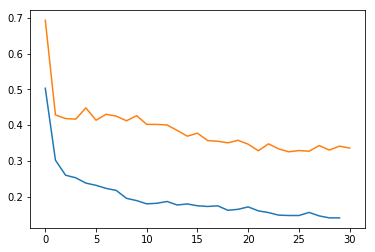

In [4]:
plot(train_losses)
plot(test_losses)